# 基于小波变换和卷积神经网络的脑电运动成像信号分类
## 数据集
数据集A是来自BCI竞赛ii的数据集III。从一名正常受试者(女性，25岁)进行记录。 本实验共280次试验，每次试验时间为9s，每次试验间隔时间为0.5s ~ 2s。 前2s比较安静，在t=2s时，听觉刺激表示试验开始，1s处出现十字“+”;然后在t=3s时，显示箭头(向左或向右)作为提示。 同时，要求被试按照箭头指示进行意象任务。采样频率为128Hz，滤波频率为0.5 ~ 30hz

数据集B有9个受试者，四个运动想象任务，即左手、右手、舌头和双脚。一个目标记录两个sessions,每个sessions包含6个run，中间有短暂的休息。 一次run包括48个实验，（4个类 4*12），每个sessions包括288次实验。 在试验开始时(t=0)，一个注视十字出现在黑色屏幕上。此外，还提出了一种短声警告音。两秒钟后(t=2s)，一个指向左、右、下或上的箭头 提示(对应左手、右手、脚或舌头四个类别中的一个)出现，并在屏幕上停留1.25秒。这促使受试者执行他们想要的运动图像任务。 信号以250hz采样，在0.5 Hz到100hz之间进行带通滤波。

In [49]:
# 数据读取
import scipy.io as sio
import numpy as np



dataSetfile = r"D:\迅雷下载\BCI_MI_CSP_DNN\dataset_BCIcomp1.mat"
testLabelfile = r"D:\迅雷下载\BCI_MI_CSP_DNN\labels_data_set_iii.mat"
dataSet = sio.loadmat(dataSetfile)
testLabel = sio.loadmat(testLabelfile)


# print(dataSet['x_train'].shape) # (1152, 3, 140)  # 1152 = 128 * 9
# print(dataSet['x_test'].shape) # (1152, 3, 140)
# print(dataSet['y_train'].shape) # (140, 1)
# print(testLabel['y_test'].shape) # (140, 1)


# concat data
dataTrain = np.concatenate([dataSet['x_train'], dataSet['x_test']], axis=2)
dataLabel = np.concatenate([dataSet['y_train'], testLabel['y_test']])
print('data shape:', dataTrain.shape) # (1152, 3, 280)
print('dataLabel.shape:',dataLabel.shape) # (280, 1)


data shape: (1152, 3, 280)
dataLabel.shape: (280, 1)


(1152, 3, 280)


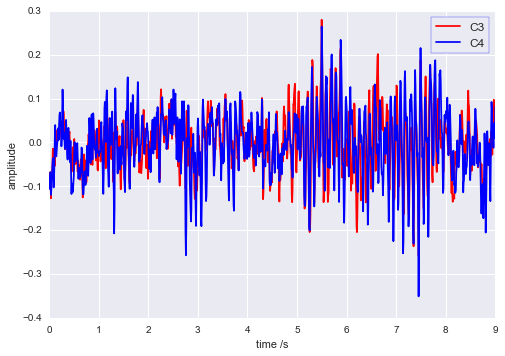

In [50]:
# 数据可视化
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn') # 设置背景样式
sampleRate = 128 # EEG 采样频率为128Hz

# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
#在指定的间隔内返回均匀间隔的数字。

print(dataTrain.shape)# 1152     (1152, 3, 280)
t = np.linspace(0,dataTrain.shape[0]/sampleRate,dataTrain.shape[0])  
i = 1
C3 = dataTrain[:, 0, i]
C4 = dataTrain[:, 2, i]
plt.plot(t, C3, 'r', label='C3') 
plt.plot(t, C4, 'b', label='C4')
plt.xlabel('time /s')
plt.ylabel('amplitude') # 振幅
plt.legend(loc='upper right',fontsize='large',frameon=True,edgecolor='blue')

##  预处理

脑电信号的预处理主要是去除信号中的噪声，滤除与运动图像任务无关的频率成分。一些数字信号中含有低频噪声，影响了信号的分析。它需要预处理，以消除信号基线。通过消除数据的趋势，分析可以集中在数据的波动上。线性趋势通常表示系统的增加或减少。小波分析可以测量信号的非线性趋势，小波分析可以对信号进行多尺度分析。从低频系数可以看出信号的基线线，并从原始信号中减去基线


脑电图的ERD/ERS现象主要体现  在8-30Hz的频段，对原始信号进行贷通滤波，选择8-30频段
肌电信号具有较宽的频率范围，较大的幅值部分分布在频率大于30hz的区域;眼球运动信号集中在5Hz以下的低频区域，尤其是前额区域。


在本实验中，我们使用空间滤波器来最大化信噪比。
common averagereference (CAR)过滤器强调大多数通道中的公共组件，并从指定的通道中删除这些组件，以增加不同通道之间的差异。
相反，如果某些组件出现在大多数通道中，但不在兴趣通道中，则会在兴趣通道上生成工件。
拉普拉斯方法的效果与CAR相似，但只使用邻域信道的一小部分。


拉普拉斯滤波：这种方法提取的是发生在第i个电极的局部活动，它使用第i个电极的信号减去四个正交的最近邻电极信号的平均值
共同平均参考（CAR）：用第i个电极的信号减去其他所有的电极信号的平均值，以增强第i个电极上的局部活动。



当受试者进行左手运动成像时，C3通道在8-12 Hz波段的功率幅值增大，即发生ERS现象，而C4通道在8-12 Hz波段的功率幅值减小，即发生ERD现象。

### 滤波器设计

通过时域转换为频域，在频域信号中去除相应频域信号，最后在逆转换还原为时域型号

滤波函数
```
scipy.signal.filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad', irlen=None)
```
输入参数：

b: 滤波器的分子系数向量

a: 滤波器的分母系数向量

x: 要过滤的数据数组。（array型）

axis: 指定要过滤的数据数组x的轴

padtype: 必须是“奇数”、“偶数”、“常数”或“无”。这决定了用于过滤器应用的填充信号的扩展类型。{‘odd', ‘even', ‘constant', None}

padlen：在应用滤波器之前在轴两端延伸X的元素数目。此值必须小于要滤波元素个数- 1。（int型或None）

method：确定处理信号边缘的方法。当method为“pad”时，填充信号；填充类型padtype和padlen决定，irlen被忽略。当method为“gust”时，使用古斯塔夫森方法，而忽略padtype和padlen。{“pad” ，“gust”}

irlen：当method为“gust”时，irlen指定滤波器的脉冲响应的长度。如果irlen是None，则脉冲响应的任何部分都被忽略。对于长信号，指定irlen可以显著改善滤波器的性能。（int型或None）

输出参数：

y:滤波后的数据数组






滤波器构造函数
```
scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba')
```
输入参数：

N:滤波器的阶数

Wn：归一化截止频率。计算公式Wn=2*截止频率/采样频率。（注意：根据采样定理，采样频率要大于两倍的信号本身最大的频率，才能还原信号。截止频率一定小于信号本身最大的频率，所以Wn一定在0和1之间）。当构造带通滤波器或者带阻滤波器时，Wn为长度为2的列表。

btype : 滤波器类型{‘lowpass', ‘highpass', ‘bandpass', ‘bandstop'},

output : 输出类型{‘ba', ‘zpk', ‘sos'},

输出参数：

b，a: IIR滤波器的分子（b）和分母（a）多项式系数向量。output='ba'

z,p,k: IIR滤波器传递函数的零点、极点和系统增益. output= 'zpk'

sos: IIR滤波器的二阶截面表示。output= 'sos'


例子
采样频率为1000Hz,滤除10hz以下和400hz以上的频率成分
则wn1 = 2*10/1000=0.02,wn2=2*400/1000=0.8。Wn=[0.02, 0.8]

```
from scipy import signal 
b, a = signal.butter(8, [0.02,0.8], 'bandpass')
filtedData = signal.filtfilt(b, a, data)  #data为要过滤的信号
```

In [51]:
'''
fir filter
butter bandpass filter
bandpass [8 30]
mu and beta rhythm
'''
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import butter, lfilter 



def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)    # 这个y的格式和data的格式一样
    return y

def butter_bandpass(lowcut, highcut, fs, order=5): # fs为采样频率
    nyq = 0.5 * fs 
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass') # 分子b，分母a
    return b, a

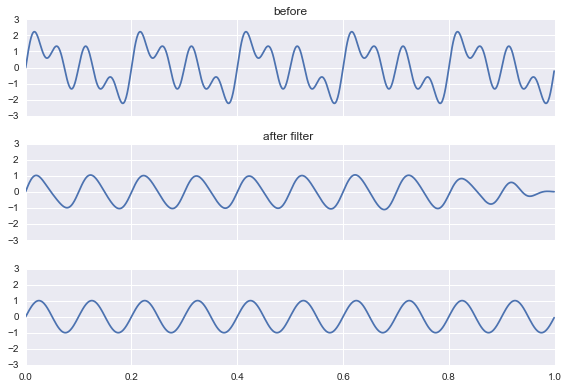

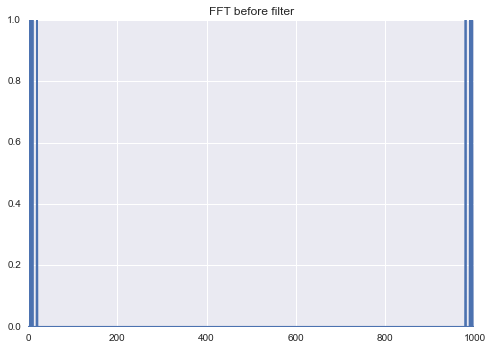

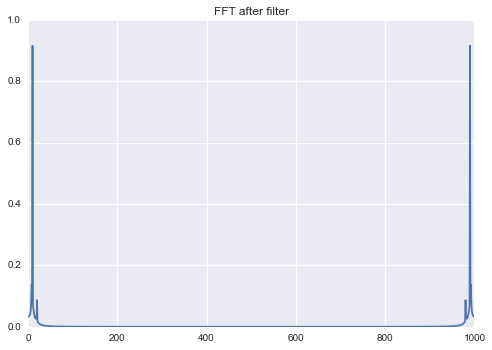

In [52]:
# test 滤波器

T  = 1
sampRat = 1000
t = np.linspace(0, T, sampRat, False)  
test1 = np.sin(2*np.pi*5*t) + np.sin(2*np.pi*10*t)++np.sin(2*np.pi*20*t)
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, test1)
ax1.set_title('before')
ax1.axis([0, 1, -3, 3])

# 带通滤波器 
test2 = butter_bandpass_filter (test1,8,18,1000)
ax2.plot(t, test2)
ax2.set_title('after filter ')
ax2.axis([0, 1, -3, 3])


# 对比
test3 = np.sin(2*np.pi*10*t)
ax3.plot(t, test3)
ax3.axis([0, 1, -3, 3])
plt.tight_layout()
plt.show()


# 傅里叶变换
f = np.linspace(0, sampRat, T*sampRat, endpoint=False)
ff = np.fft.fft(test1)
ff = np.abs(ff)*2/T/sampRat
plt.figure()
plt.plot(f, ff)
plt.title('FFT before filter')
plt.show()

ff1 = np.fft.fft(test2)
ff1 = np.abs(ff1)*2/T/sampRat
plt.figure()
plt.plot(f, ff1)
plt.title('FFT after filter')
plt.show()

In [53]:
print(dataTrain.shape)
print(sampleRate)
dataTrain = butter_bandpass_filter(dataTrain,8,30,sampleRate)
print("滤波完成")

(1152, 3, 280)
128
滤波完成


## 小波变换

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
Class of continuous wavelet functions：
['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


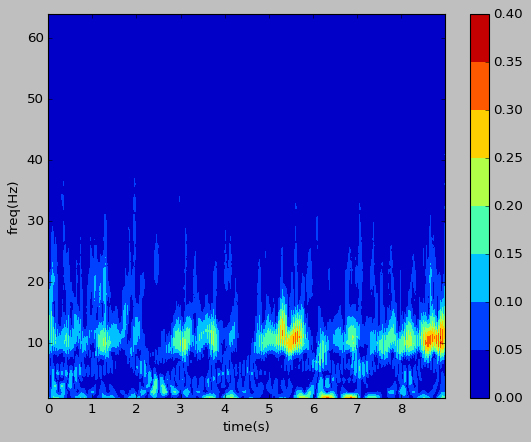

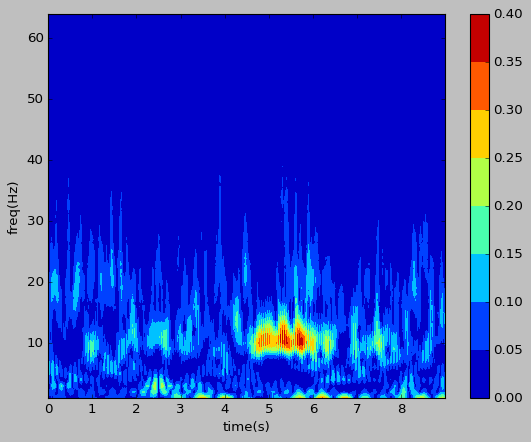

In [54]:
# Wavelet transform generates time-frequency graph   小波变换生成时频图
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pywt


print(plt.style.available)
plt.style.use('classic')


wavlist = pywt.wavelist(kind='continuous') # 各种连续的小波已经被实现
print("Class of continuous wavelet functions：")
print(wavlist)


sampling_rate = 128 
t = np.arange(0,9.0,1.0/sampling_rate)
wavename = 'morl'    # "cmorB-C" where B is the bandwidth and C is the center frequency.其中B是带宽，C是中心频率。
# frequencies = pywt.scale2frequency('cmor1.5-0.5', [1, 2, 3, 4]) / (1/sampling_rate)
# print(frequencies)
totalscal = 64    # scale 
fc = pywt.central_frequency(wavename) #  central frequency
cparam = 2 * fc * totalscal
scales = cparam/np.arange(1,totalscal+1)
# C3 channel
[cwtmatr, frequencies] = pywt.cwt(dataTrain[:,0,3],scales,wavename,1.0/sampling_rate) # continuous wavelet transform
fig = plt.figure(1)
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"freq(Hz)")
plt.xlabel(u"time(s)")
plt.colorbar()
# fig.savefig('C3.png')
fig = plt.figure(2)
# C4 channel
[cwtmatr, frequencies] = pywt.cwt(dataTrain[:,2,3],scales,wavename,1.0/sampling_rate) #连续小波变换
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"freq(Hz)")
plt.xlabel(u"time(s)")
plt.colorbar()
# fig.savefig('C4.png')

In [55]:
'''
Wavelet transfrom 
Time-frequency diagram combination
select 3-6s EEG data every trial
'''
TimeStart = 3                     # start time
TimeEnd = 6                       # end time 
sampling_rate = 128 
samplePointStart=TimeStart*sampling_rate
samplePointEnd=TimeEnd*sampling_rate

# data capture 3-6s
dataTrainC3 = dataTrain[samplePointStart:samplePointEnd,0,:]
dataTrianC4 = dataTrain[samplePointStart:samplePointEnd,2,:]
sampling_rate = 128 

wavename = 'morl'    # "cmorB-C" where B is the bandwidth and C is the center frequency.
# frequencies = pywt.scale2frequency('cmor1.5-0.5', [1, 2, 3, 4]) / (1/sampling_rate)
# print(frequencies)
totalscal = 64    # scale 
fc = pywt.central_frequency(wavename) #  central frequency
cparam = 2 * fc * totalscal
scales = cparam/np.arange(1,totalscal+1)
t = np.arange(3,6.0,1.0/sampling_rate)


# wavelet transfrom 
for i in range(280):
    figureName = str(i)
    [cwtmatr3, frequencies3] = pywt.cwt(dataTrainC3[:,i],scales,wavename,1.0/sampling_rate) 
    [cwtmatr4, frequencies4] = pywt.cwt(dataTrianC4[:,i],scales,wavename,1.0/sampling_rate) 
    cwtmatr = np.concatenate([abs(cwtmatr3[7:30,:]), abs(cwtmatr4[7:30,:])],axis=0)   # the sequence is C3 then C4
    fig = plt.figure()
    plt.contourf(cwtmatr) # 用来绘制等高线的
    plt.xticks([])  # remove x
    plt.yticks([])  # remove y
    plt.axis('off') # remove axis
    fig.set_size_inches(800/100.0,600/100.0)#  set pixels width*height
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0) # 调整布局
    plt.margins(0,0)
    #plt.savefig(path)
    if dataLabel[i][0] == 1:
        filepath = r'D:\workspace\Jupyter Notebook\zx_CNN_wavelet_MI\wavelet_feature\morl\1\{}.jpg'.format(figureName)
    if dataLabel[i][0] == 2:
        filepath = r'D:\workspace\Jupyter Notebook\zx_CNN_wavelet_MI\wavelet_feature\morl\2\{}.jpg'.format(figureName)
    #print(filepath)  
    fig.savefig(filepath)
    fig.clear()
    #print('The {} sample wavelet transform is completed'.format(i))
    
print('wavelet transfrom completed')
plt.close()    

#plt.colorbar()

<ipython-input-55-d5ad973d7c42>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


wavelet transfrom completed


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# CNN模型
一个典型的CNN网络有以下几层:输入层、卷积层、池化层、完全连接层、输出层。卷积核提取输入的局部接受域特征，然后将该特征作为池化层的输入。

CNN的抽象能力与需要学习的层数和参数正相关。

我们交替计算卷积层和池化层，使得特征图的大小减小，通道数量增加。到全连通层时，将之前得到的特征进行扁平化，最终通过前馈网络实现分类结果

CNN中的经典模型更适合有足够数据的训练，在BCI中并不是适合。BCI数据集难以训练，更容易出现过拟合。针对小数据集，提出一种2层卷积网络。输入图像统一调整为64*64.内核大小也会相应的调整。本文采用了两种类型的核，一种是二维核一种是一维核。

In [56]:
# load feature dataset
import os
import numpy as np
def get_file(filename):
    ''' load time frequency diagram '''
    dataTrain = list()
    labelTrain = list()
    for label in os.listdir(filename):
        for pic in os.listdir(filename+label):
            dataTrain.append(filename+label+'/'+pic)  # shuffle data
            labelTrain.append(int(label))
    temp = np.array([dataTrain, labelTrain])  # （2,280）         
    temp = np.transpose(temp)   # 280*2
    np.random.shuffle(temp)  #洗牌
    image_list = temp[:,0]
    label_list = temp[:,1]
    label_list = [int(i) for i in label_list]  
    return image_list, label_list
pathname = r"D:/workspace/Jupyter Notebook/zx_CNN_wavelet_MI/wavelet_feature/morl/"
image_list, label_list = get_file(pathname) 

print(len(image_list),len(label_list))
print(image_list[10])

280 280
D:/workspace/Jupyter Notebook/zx_CNN_wavelet_MI/wavelet_feature/morl/1/243.jpg


(600, 800, 3)


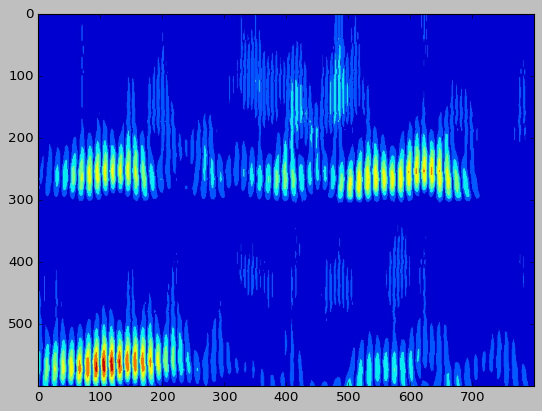

In [57]:
# read figure Demo
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# read binary data
image_raw = tf.io.gfile.GFile(image_list[10],'rb').read()
# tf decode
img = tf.image.decode_jpeg(image_raw)  #Tensor  将JPEG编码图像解码为uint8张量.
 
with tf.compat.v1.Session() as sess:
   img_ = img.eval()  # 等价于sess.run(img)
   print(img_.shape)
 
plt.figure(1)
plt.imshow(img_)
plt.show()

In [58]:
"""
X_Train train data 280 samples
Y_Train train label
"""

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


# read train data  figure-->tensor
# read_file 
# decode_jpeg
X = np.empty([280,64,64,3])
with tf.compat.v1.Session() as sess:
    for i in range(len(image_list)):
        # 读取图像文件
        image_raw_data = tf.io.gfile.GFile(image_list[i],'rb').read() 
        # 将图像文件解码为tensor
        image_data = tf.image.decode_jpeg(image_raw_data)
        # 改变张量的形状
        resized = tf.image.resize_images(image_data, [64,64],method=0)  
        #resized = tf.image.resize(image_data, [64,64],method=0)  
        resized = np.asarray(resized.eval(),dtype='uint8')      # asarray 生成数组 深拷贝不复制对象   .eval()等价于 sess.run(resized)
        X[i,:,:,:]=resized  

# train data
X_Train = X[:,:,:,:]
Y = np.subtract(np.array(label_list), 1)
Y = Y.reshape([280,1])
V = tf.one_hot(Y, depth=2,axis=1,dtype=tf.float32) # 返回一个one_hot张量
session = tf.Session()
Y_Train = session.run(V)
session.close()
# resize
Y_Train = Y_Train.reshape([280,2])
#  normalization
X_Train = X_Train/255.
print ("X_Train shape: " + str(X_Train.shape))
print ("Y_Train shape: " + str(Y_Train.shape))

X_Train shape: (280, 64, 64, 3)
Y_Train shape: (280, 2)


In [59]:
# Keras 序贯模型  deep learning API

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam            # 优化器
# import keras 



input_shape = X_Train.shape[1:]
# print(input_shape)  # (64, 64, 3)
num_classes = 2

model = Sequential()

model.add(Conv2D(16, (4,4), padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', name = 'conv2d_1'))
model.add(Activation('relu',name = 'activation_1'))
model.add(MaxPool2D(pool_size=(8,8),name = 'maxpool2d_1'))
model.add(Dropout(0.25,name = 'dropout_1'))

model.add(Conv2D(32, (4,4), padding = 'same',kernel_initializer = 'he_normal', name = 'conv2d_2'))
model.add(Activation('relu',name = 'activation_2'))
model.add(MaxPool2D(pool_size=(2,2),name = 'maxpool2d_2'))
model.add(Dropout(0.25,name = 'dropout_2'))

model.add(Flatten(name = 'flatten_1'))
model.add(Dense(240,kernel_initializer='he_normal',name='dense_1'))
model.add(Activation('relu',name='activation_3'))
model.add(Dropout(0.5,name = 'dropout_3'))
model.add(Dense(num_classes, kernel_initializer='he_normal',name='dense_2'))
model.add(Activation('softmax',name='activation_4'))
model.summary()

# 优化方法
opt = keras.optimizers.Adam(lr=0.0003, decay = 1e-6)
# 编译模型
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        784       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          8224      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 4, 4, 32)         

D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [60]:
# train model
epochs = 300
history = model.fit(X_Train, Y_Train, shuffle=True, batch_size=8, epochs=epochs, verbose=1, validation_split=0.3)

Train on 196 samples, validate on 84 samples
Epoch 1/300
168/196 [========================>.....] - ETA: 0s - loss: 0.9599 - acc: 0.5357

D:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


196/196 [==============================] - 1s 4ms/sample - loss: 0.9675 - acc: 0.5357 - val_loss: 0.6606 - val_acc: 0.6429
Epoch 2/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.8982 - acc: 0.4949 - val_loss: 0.6896 - val_acc: 0.5119
Epoch 3/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.7609 - acc: 0.5408 - val_loss: 0.6644 - val_acc: 0.6190
Epoch 4/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.7546 - acc: 0.5510 - val_loss: 0.6629 - val_acc: 0.5833
Epoch 5/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.7107 - acc: 0.5918 - val_loss: 0.6590 - val_acc: 0.6667
Epoch 6/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.7866 - acc: 0.5255 - val_loss: 0.6864 - val_acc: 0.5000
Epoch 7/300
196/196 [==============================] - 0s 2ms/sample - loss: 0.7249 - acc: 0.5663 - val_loss: 0.6435 - val_acc: 0.6786
Epoch 8/300
196/196 [==============================] - 0s 2ms/sampl

In [62]:
# cross validation
'''
#learning_rate = 0.01,num_epochs = 500, minibatch_size = 16
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
skf=StratifiedKFold(n_splits=5)
skf.get_n_splits(X,b)
print(skf)
for train_index,test_index in skf.split(X,b):
    #print("Train Index:",train_index,",Test Index:",test_index)
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
    
    X_train = X_train/255.
    X_test = X_test/255.
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))
#     print ("X_train shape: " + str(X_train.shape))
#     print ("Y_train shape: " + str(y_train.shape))
#     print ("X_test shape: " + str(X_test.shape))
#     print ("Y_test shape: " + str(y_test.shape))
    
    _, _, parameters = model(X_train, y_train, X_test, y_test)
    
    
    with open('2003.pkl','rb') as f:
            pred=pickle.load(f)
            
    true=np.argmax(y_test,1)+1
    confusion_matrix(true,pred)
    print(classification_report(true,pred))
'''

'\n#learning_rate = 0.01,num_epochs = 500, minibatch_size = 16\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import confusion_matrix, classification_report\nskf=StratifiedKFold(n_splits=5)\nskf.get_n_splits(X,b)\nprint(skf)\nfor train_index,test_index in skf.split(X,b):\n    #print("Train Index:",train_index,",Test Index:",test_index)\n    X_train,X_test=X[train_index],X[test_index]\n    y_train,y_test=Y[train_index],Y[test_index]\n    \n    X_train = X_train/255.\n    X_test = X_test/255.\n    print ("number of training examples = " + str(X_train.shape[0]))\n    print ("number of test examples = " + str(X_test.shape[0]))\n#     print ("X_train shape: " + str(X_train.shape))\n#     print ("Y_train shape: " + str(y_train.shape))\n#     print ("X_test shape: " + str(X_test.shape))\n#     print ("Y_test shape: " + str(y_test.shape))\n    \n    _, _, parameters = model(X_train, y_train, X_test, y_test)\n    \n    \n    with open(\'2003.pkl\',\'rb\') as f:\n    

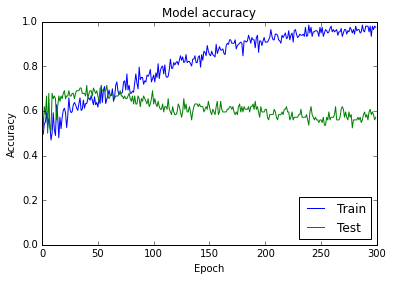

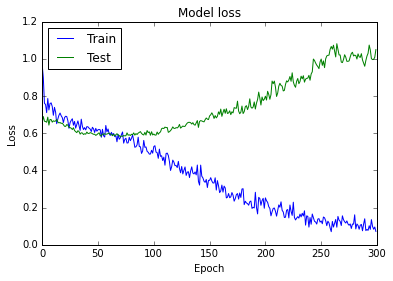

In [63]:
#  Visualization of training process
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.ylim(0,1)

plt.figure(1)
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')